In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 64
oversample = 4

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)
ddir = "../data/MAST_2024-08-27T07_49_07.684Z/"
#ddir = '../data/MAST_2024-07-07T03_17_36.223Z/'
fname = ddir + 'HST/n8ku01050_mos.fits'
fname = ddir + 'HST/n8ku01ffq_cal.fits'
new_nans = True

if new_nans:
    bad = np.zeros((wid,wid), dtype=int)

exposure = exposure_from_file(fname, SinglePointFit(), crop=wid, extra_bad=bad)
exposures = [exposure]

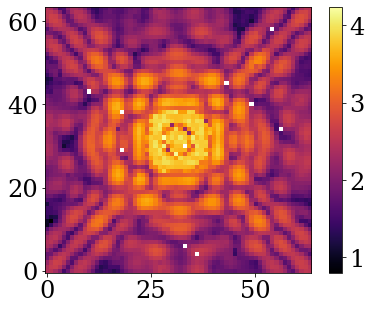

In [4]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

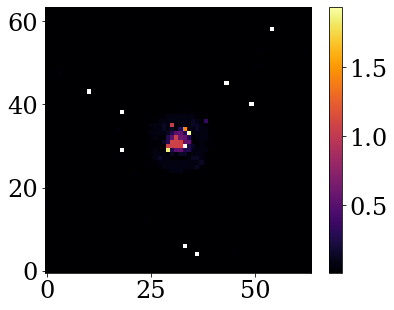

In [5]:
plt.imshow(exposures[0].err)
plt.colorbar()

In [6]:
params = {
    "fluxes": {},
    "positions": {},
    "aberrations": {},#np.zeros(8),#np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "cold_mask_shift": {}, #np.asarray([-0.05, -0.05]),
    "cold_mask_rot": {},#np.asarray([np.pi/4]),
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0431
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.nansum(exp.data)
    #params["aberrations"] = injected_params["aberrations"]
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([0.12,0.12])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = np.pi/4

model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [7]:
params

ModelParams(
  params={
    'fluxes':
    {'n8ku01ffq': f32[]},
    'positions':
    {'n8ku01ffq': f32[2]},
    'aberrations':
    {'n8ku01ffq': f32[19]},
    'cold_mask_shift':
    {'n8ku01ffq': f32[2]},
    'cold_mask_rot':
    {'n8ku01ffq': -0.7853981633974483},
    'outer_radius':
    1.146,
    'secondary_radius':
    0.44639999999999996,
    'spider_width':
    0.0924,
    'scale':
    0.0431
  }
)

In [8]:
print(params.params)

{'fluxes': {'n8ku01ffq': Array(168947.97, dtype=float32)}, 'positions': {'n8ku01ffq': Array([0., 0.], dtype=float32)}, 'aberrations': {'n8ku01ffq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)}, 'cold_mask_shift': {'n8ku01ffq': Array([0.12, 0.12], dtype=float32)}, 'cold_mask_rot': {'n8ku01ffq': -0.7853981633974483}, 'outer_radius': 1.146, 'secondary_radius': 0.44639999999999996, 'spider_width': 0.0924, 'scale': 0.0431}


In [9]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]

g = 1e-2

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*10, 0),
    "cold_mask_shift": opt(g*5, 50),
    #"cold_mask_rot": opt(g*20, 50),
    "aberrations": opt(g*5,25),
    "outer_radius": opt(g*30, 50),
    "secondary_radius": opt(g*30,50),
    "spider_width": opt(g*30,50),
}

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*10, 0),
    "cold_mask_shift": opt(g*10, 50),
    #"cold_mask_rot": opt(g*20, 50),
    "aberrations": opt(g*3,25),
    "outer_radius": opt(g*50, 60),
    "secondary_radius": opt(g*5,70),
    #"spider_width": opt(g*40,80),
}

g = 5e-3

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*2, 0),
    "cold_mask_shift": opt(g*2, 50),
    #"cold_mask_rot": opt(g*20, 50),
    "aberrations": opt(g*10,25),
    "outer_radius": opt(g*50, 60),
    "secondary_radius": opt(g*5,70),
    "spider_width": opt(g*40,80),
}


g = 5e-3

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*10, 0),
    "cold_mask_shift": opt(g*500, 50),
    "cold_mask_rot": opt(g*50, 50),
    "scale": opt(g*1, 20),
    "aberrations": opt(g*0.5,25),
    "outer_radius": opt(g*50, 60),
    "secondary_radius": opt(g*50,70),
    "spider_width": opt(g*30,80),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [10]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [11]:
rc = True
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [12]:
lrs

NICMOSModel(
  params={
    'aberrations':
    {'n8ku01ffq': f32[19]},
    'cold_mask_rot':
    {'n8ku01ffq': f32[]},
    'cold_mask_shift':
    {'n8ku01ffq': f32[2]},
    'fluxes':
    {'n8ku01ffq': f32[]},
    'outer_radius':
    f32[],
    'positions':
    {'n8ku01ffq': f32[2]},
    'scale':
    f32[],
    'secondary_radius':
    f32[],
    'spider_width':
    f32[]
  },
  filters={'F170M': None},
  optics=NICMOSOptics(
    wf_npixels=None,
    diameter=None,
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=None,
        transformation=None,
        apertures={
          'cold_mask':
          NICMOSColdMask(
            normalise=None,
            transformation=CoordTransform(
              translation=None,
              rotation=None,
              compression=None,
              shear=None
            ),
            apertures={
              'outer':
              CircularAperture(
                normalise=None,
                transformation=No

In [13]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(120)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)

    models.append(params)
    losses.append(loss)


  0%|          | 0/120 [00:00<?, ?it/s]

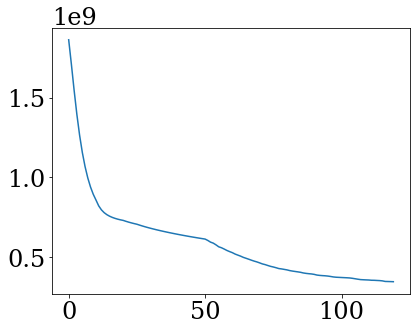

In [14]:
plt.plot(losses)

In [15]:
params.params

{'aberrations': {'n8ku01ffq': Array([ 1.6994032e-09,  1.0935577e-08,  1.5343952e-08, -9.8967667e-10,
         -3.4770498e-09, -1.2953144e-09, -9.7857766e-10, -2.9207605e-09,
         -2.1371040e-09, -4.5048787e-09,  3.2544061e-11, -2.3572364e-09,
          5.8804548e-09, -1.4762032e-09,  2.6414135e-10,  1.8511432e-09,
          4.1988824e-10, -3.8439141e-10, -2.7533702e-09], dtype=float32)},
 'cold_mask_rot': {'n8ku01ffq': Array(-0.7864693, dtype=float32)},
 'cold_mask_shift': {'n8ku01ffq': Array([0.08776839, 0.07962114], dtype=float32)},
 'fluxes': {'n8ku01ffq': Array(180369.28, dtype=float32)},
 'outer_radius': Array(1.1504833, dtype=float32),
 'positions': {'n8ku01ffq': Array([-3.3073423e-08, -1.0564442e-07], dtype=float32)},
 'scale': Array(0.04369678, dtype=float32),
 'secondary_radius': Array(0.44237697, dtype=float32),
 'spider_width': Array(0.09406555, dtype=float32)}

9


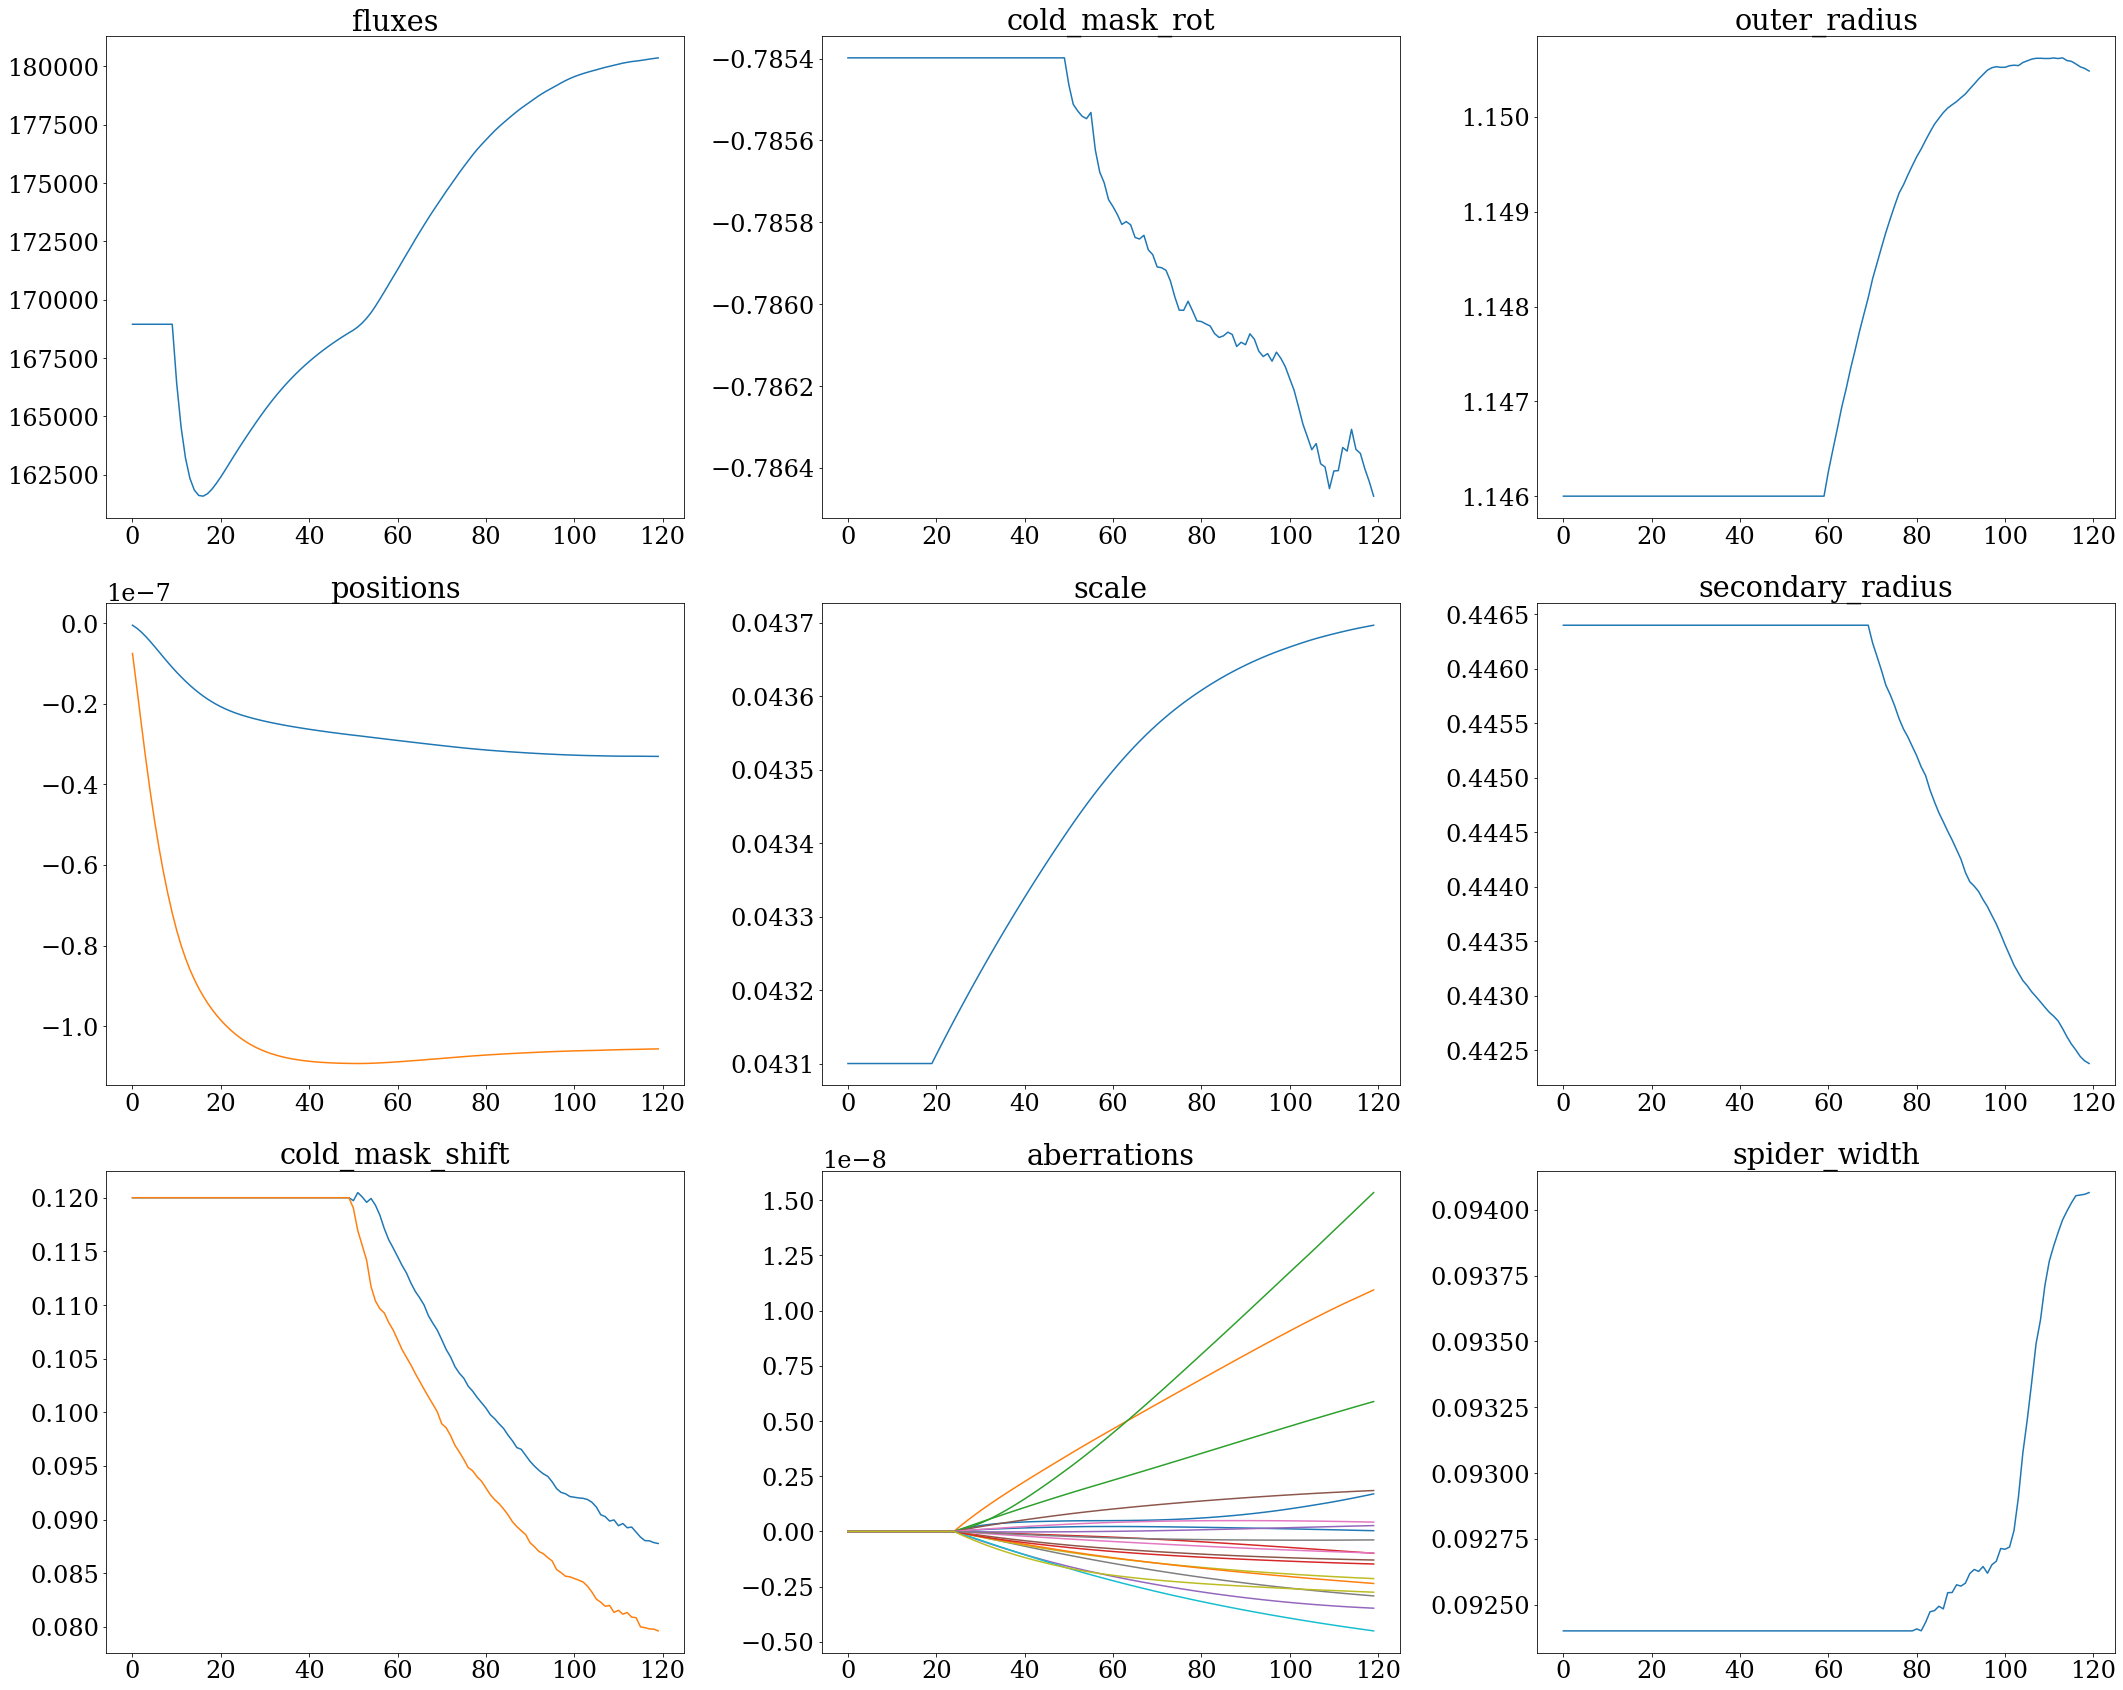

In [16]:
xw = 3
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", "cold_mask_shift", "cold_mask_rot"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

1.861145e+09, 3.479396e+08


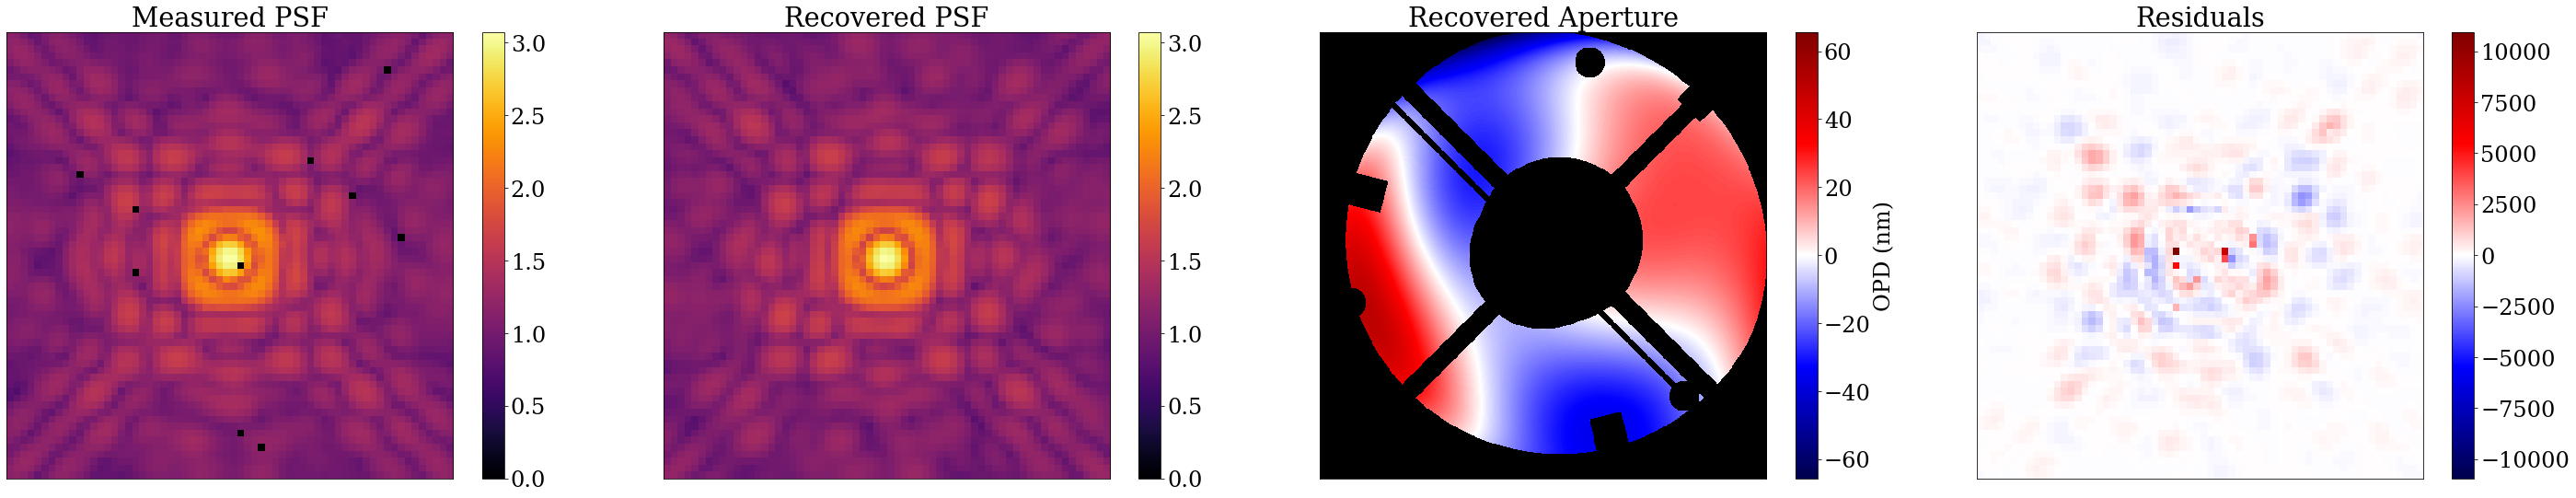

In [17]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,4, figsize=(40,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]

model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


In [18]:
resid = (exp.data - exp.fit(model,exp))/exp.data
#print(np.nanmedian(np.abs(resid[50:-50,50:-50])))
#plt.imshow((np.abs(resid[50:-50,50:-50])))
#plt.colorbar()

In [19]:
if new_nans:
    nanmap = np.ones((wid,wid))
    for i in range(30):
        lpdf = posterior(model,exp,return_im=True)*nanmap
        ind = np.unravel_index(np.nanargmax(lpdf),lpdf.shape)
        nanmap = nanmap.at[ind].set(np.nan)

    

    bad = np.isnan(lpdf)

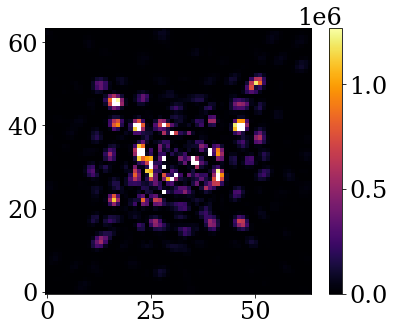

In [20]:
lpdf = posterior(model,exp,return_im=True)*nanmap
plt.imshow(lpdf)
plt.colorbar()

In [21]:
"""fig, axs = plt.subplots(1,3, figsize=(32,8))
fig.tight_layout()

cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)


model = ModelParams(injected_params).inject(model)
optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd_t = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd_t))
apt =axs[0].imshow(support_mask*opd_t,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[0]).set_label("OPD (nm)")

model = params.inject(model)
optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd_r = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd_r))
apt =axs[1].imshow(support_mask*opd_r,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[1]).set_label("OPD (nm)")

resid = opd_t - opd_r
olim = np.max(np.abs(resid))
apt =axs[2].imshow(resid,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("residual (nm)")
axs[2].set_title("Aberration Residuals")
axs[1].set_title("Recovered Aberrations")
axs[0].set_title("Injected Aberrations")

"""


'fig, axs = plt.subplots(1,3, figsize=(32,8))\nfig.tight_layout()\n\ncmap = matplotlib.colormaps[\'seismic\']\ncmap.set_bad(\'k\',1)\n\n\nmodel = ModelParams(injected_params).inject(model)\noptics = exp.fit.update_optics(model, exp)\n\nsupport = optics.transmission(coords,2.4/512)\nsupport_mask = support.at[support < .5].set(np.nan)\n\nopd_t = optics.AberratedAperture.eval_basis(coords)*1e9\nolim = np.max(np.abs(opd_t))\napt =axs[0].imshow(support_mask*opd_t,cmap=cmap,vmin=-olim, vmax=olim)\nplt.colorbar(apt, ax=axs[0]).set_label("OPD (nm)")\n\nmodel = params.inject(model)\noptics = exp.fit.update_optics(model, exp)\n\nsupport = optics.transmission(coords,2.4/512)\nsupport_mask = support.at[support < .5].set(np.nan)\n\nopd_r = optics.AberratedAperture.eval_basis(coords)*1e9\nolim = np.max(np.abs(opd_r))\napt =axs[1].imshow(support_mask*opd_r,cmap=cmap,vmin=-olim, vmax=olim)\nplt.colorbar(apt, ax=axs[1]).set_label("OPD (nm)")\n\nresid = opd_t - opd_r\nolim = np.max(np.abs(resid))\napt =

In [22]:
params.params

{'aberrations': {'n8ku01ffq': Array([ 1.6994032e-09,  1.0935577e-08,  1.5343952e-08, -9.8967667e-10,
         -3.4770498e-09, -1.2953144e-09, -9.7857766e-10, -2.9207605e-09,
         -2.1371040e-09, -4.5048787e-09,  3.2544061e-11, -2.3572364e-09,
          5.8804548e-09, -1.4762032e-09,  2.6414135e-10,  1.8511432e-09,
          4.1988824e-10, -3.8439141e-10, -2.7533702e-09], dtype=float32)},
 'cold_mask_rot': {'n8ku01ffq': Array(-0.7864693, dtype=float32)},
 'cold_mask_shift': {'n8ku01ffq': Array([0.08776839, 0.07962114], dtype=float32)},
 'fluxes': {'n8ku01ffq': Array(180369.28, dtype=float32)},
 'outer_radius': Array(1.1504833, dtype=float32),
 'positions': {'n8ku01ffq': Array([-3.3073423e-08, -1.0564442e-07], dtype=float32)},
 'scale': Array(0.04369678, dtype=float32),
 'secondary_radius': Array(0.44237697, dtype=float32),
 'spider_width': Array(0.09406555, dtype=float32)}

In [23]:
optics.psf_pixel_scale

Array(0.04369678, dtype=float32)